In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import scipy as sc
from itertools import islice
from random import sample
seed = 0

In [ ]:
#Please write your code here, based on the pseudocode provided below
path = "./nsfnet.json"      
#Function get_network_mcf_json(fp: string, link_capacity: integer) -> Graph:
def get_network_mcf_json(fp: str, link_capacity: int) -> nx.Graph:

    with open(fp, mode='r') as file:
        in_data = json.load(file)

    G = nx.node_link_graph(in_data)
    nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), with_labels=True)
    nx.set_edge_attributes(G, link_capacity, "available_capacity")
    
    return G
#get_network_mcf_json(path, 10)

In [ ]:
#Please write your code here, based on the pseudocode provided below
from typing import List, Tuple 

#Function generate_demands(G: Graph, total_flow: integer) -> List of Tuples of integers:
def generate_demands(G: nx.Graph, total_flow: int) -> List[Tuple[int, int, int]]:
    #Initialize an empty list demands
    demands = []
    nodes = G.nodes()
    for i in range(total_flow):          #For each iteration in the range of total_flow:
        src, dst = np.random.choice(G.number_of_nodes(), size=(2,), replace=False)  #Randomly select two distinct nodes, src and dst, from the nodes in graph G
        rate = np.random.randint(100, 1000)
        demands.append((src, dst, rate))     #Append the tuple (src, dst) to the demands list

    return demands   #Return the demands list

In [ ]:
#Please write your code here, based on the pseudocode provided below

#Function get_ksp(G: Graph, n_paths: integer, metric: string) -> Dictionary with tuple keys and list values:
def get_ksp(G: nx.Graph, n_paths: int, metric: str) -> dict[tuple[int, int]: list[int]]:
    
    ksp = {}                #Initialize an empty dictionary ksp
    for i in G.nodes:       #For each node i in the graph G:
        for j in G.nodes:   #For each node j in the graph G:
            if i < j:       #If i is less than j:
                            #Find the first n_paths shortest paths between nodes i and j in G using the specified metric
                paths = list(islice(nx.shortest_simple_paths(G, i, j, metric), n_paths))
                ksp[i, j] = paths
                ksp[j, i] = paths
                
    return ksp  #Return the dictionary ksp

In [6]:
#define a function that considers the graph G, demands, and ksp to route the demands
def sap_mmcf(G: nx.Graph, demands: list, ksp: dict) -> tuple[int, list]:
    n_routed_demands = 0
    routed_demands = []
    #For each demand (src, dst) in the demands list:
    for src, dst in demands:
        #For each path in the ksp[(src, dst)] list:
        for path in ksp[src, dst]:
            #Check if the path is free (i.e., all edges have available_capacity > 0)
            is_path_free = True
            #For each edge in the path:
            for i in range(len(path)-1):
                #If the available_capacity of the edge is 0, set is_path_free to False and break
                if G[path[i]][path[i+1]]['available_capacity'] == 0:
                    is_path_free = False
                    continue
            #If the path is free:    
            if is_path_free:
                #Decrement the available_capacity of each edge in the path by 1
                for i in range(len(path)-1):
                    G[path[i]][path[i+1]]['available_capacity'] -= 1
                n_routed_demands += 1
                #Append the demand (src, dst, path) to the routed_demands list
                routed_demands.append((src, dst, path))
                break
    #Return the number of routed demands and the list of routed demands
    return n_routed_demands, routed_demands

In [7]:
#Function get_network_rwa_json(fp: string, n_wavelengths: integer) -> Graph:
def get_network_rwa_json(fp: str, n_wavelengths: int) -> nx.Graph:
    #Open the file at path fp in read mode as file
    with open(fp, mode='r') as file:
        in_data = json.load(file)
        #Load JSON data from file into data
    G = nx.node_link_graph(in_data)
    #Convert data into a graph G using node-link format
    #Initialize an empty dictionary available_wavelengths
    available_wavelengths = {}
    #For each edge in G:
    for edge in G.edges():
        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8
        available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)
    #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    nx.set_edge_attributes(G, available_wavelengths, "available_wavelengths")
    #Set the graph attribute "n_wavelengths" in G to n_wavelengths
    G.graph["n_wavelengths"] = n_wavelengths    #Return the graph G
    return G

In [46]:
#Function sap_ff_rwa(G: Graph, demands: List of tuples, ksp: Dictionary) -> Tuple of integer and List:
def sap_ff_rwa(G: nx.Graph, demands: list, ksp: dict) -> tuple[int, list]:
    #Initialize n_routed_demands to 0
    n_routed_demands = 0
    #Initialize an empty list routed_demands
    routed_demands = []
    #For each source-destination pair (src, dst) in demands:
    for (src,dst,rate) in demands:
        #For each path in ksp[(src, dst)]:
        for path in ksp[(src,dst)]:
            #For each wavelength wav from 0 to the number of wavelengths in G:
            for wav in range(G.graph["n_wavelengths"]):
                for i in range(len(path)-1):
                    is_wavelength_free = True       #Set is_wavelength_free to True
                    #For each consecutive pair of nodes in the path:
                    #If the available wavelength for the edge between these nodes is not free (value is 0):
                    if G[path[i]][path[i+1]]["available_wavelengths"][wav] == 0:
                        is_wavelength_free = False  #Set is_wavelength_free to False
                        break                       #Break out of the edge-checking loop

                if is_wavelength_free:    #If is_wavelength_free is True:
                    break             #Break out of the wavelength loop

                
            if is_wavelength_free:
                for i in range(len(path)-1):          #For each consecutive pair of nodes in the path:
                    #Assert that the wavelength wav on the edge between these nodes is free (value is 1)
                    assert(G[path[i]][path[i+1]]["available_wavelengths"][wav] == 1)
                    #Set the wavelength wav on this edge to unavailable (value is 0)
                    G[path[i]][path[i+1]]["available_wavelengths"][wav] = 0
                #Increment n_routed_demands by 1
                n_routed_demands += 1
                #Append the tuple (src, dst, path, wav) to routed_demands
                routed_demands.append((src, dst, path, wav))
                break
                #Break out of the path loop

    #Return the tuple (n_routed_demands, routed_demands)
    return n_routed_demands, routed_demands

def sap_ff_rwa_variable(G: nx.Graph, demands: list, ksp: dict, dataPerWave: int, modReach: int) -> tuple[int, list]:
    # Initialize the number of successfully routed demands and the list to store routed demands
    n_routed_demands = 0
    routed_demands = []
    num_utilized_wavelengths = 0
    num_amplifiers_needed = 0
    # Iterate over each demand (source, destination, required rate)
    for src, dst, rate in demands:
        # Calculate the number of wavelengths required to satisfy the demand
        num_waves_needed = (rate + dataPerWave - 1) // dataPerWave  # Ceiling division to ensure enough wavelengths
        
        # Iterate over all paths for the source-destination pair in the ksp dictionary
        for path in ksp[(src, dst)]:
            available_waves = []

            # Iterate over each wavelength to find a set of consecutive free wavelengths
            for wav in range(G.graph["n_wavelengths"]):
                is_wavelength_free = True

                for i in range(len(path) - 1):
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

                # If enough wavelengths are found, break out of the loop
                if len(available_waves) == num_waves_needed:
                    break

            # Check if enough wavelengths were found to route the demand
            if len(available_waves) == num_waves_needed:
                for wav in available_waves:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["available_wavelengths"][wav] = 0
                        num_utilized_wavelengths += 1
                        num_amplifiers_needed += G[path[i]][path[i + 1]]["length"] // modReach  # onsidering the node as a amplifier

                # Record the routed demand information
                n_routed_demands += 1
                routed_demands.append((src, dst, path, available_waves))
                break
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_amplifiers_needed)
    return n_routed_demands, routed_demands



In [20]:

def runHeuristic(G: nx.Graph, demands: list, num_spectrum: int, plot_usage: bool, n_wavelengths: int, ratePerWave: int, modReach: int) -> tuple[int, bool]:
    ksp = get_ksp(G, 5, 'length')
    print(f'We generated {len(demands)} demands')
    #n_routed_demands, routed_demands = sap_ff_rwa(G,demands, ksp)
    n_routed_demands, routed_demands = sap_ff_rwa_variable(G,demands, ksp, ratePerWave, modReach)
    print(f'We routed {n_routed_demands} demands')
    # Dictionary to store the indexes of demands routed on each edge
    edge_demand_map = {edge: [] for edge in G.edges}
    if plot_usage:
        plt_1 = plt.figure(figsize=(16, 9))
        nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)
        alpha_step = round(1/n_wavelengths, 2)

    for demand_index, demand in enumerate(routed_demands):
        route = demand[-2]
        route_el = list(zip(route, route[1:]))
        num_spectrum += len(route_el)
        
        # Update the edge_demand_map with the current demand index
        for edge in route_el:
            if edge in edge_demand_map:
                edge_demand_map[edge].append(demand_index)
            elif (edge[1], edge[0]) in edge_demand_map:
                edge_demand_map[(edge[1], edge[0])].append(demand_index)
            else:
                edge_demand_map[edge] = [demand_index]
                
        if plot_usage:
            nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, "pos"), edgelist=route_el, width=10, alpha=alpha_step, edge_color='red')
            #label every edge with all indexes of demands it is carrying

    if plot_usage:
        # Label every edge with the indexes of demands it is carrying
        edge_labels = {edge: ','.join(map(str, indexes)) for edge, indexes in edge_demand_map.items() if indexes}
        nx.draw_networkx_edge_labels(G, pos=nx.get_node_attributes(G, 'pos'), edge_labels=edge_labels, font_size=11, font_weight='bold')

        # nx.draw_networkx_edge_labels(
        #     G, pos=nx.get_node_attributes(G, 'pos'),
        #     edge_labels=nx.get_edge_attributes(G, 'available_wavelengths'),
        #     bbox=dict(alpha=0),
        #     font_size=11,
        #     font_weight='bold',
        #     verticalalignment='center')
    print(f"Spectrum occupation is: {num_spectrum}")
    if n_routed_demands == len(demands):
        print("All demands were routed")
        return num_spectrum, True
    else:
        print(f"Only {n_routed_demands} demands were routed")
        return num_spectrum, False

In [10]:

def prepare_ilp(G: nx.Graph, demands: list, n_wavelengths: int) -> tuple:
    # Prepare sets of the ILP# Set of nodes
    V = list(G.nodes)

    # print(V)

    # Set of edges
    E_u = list(G.edges())
    E = []
    for e in E_u:
        E.append(e)
        E.append((e[1], e[0]))
    # print(E)
    
    #print(demands)
    # set of demands
    K = list(range(len(demands)))
    # print(K)
    # source node and destination node of the demands
    s = {}
    t = {}
    for k in K:
        s[k] = demands[k][0]
        t[k] = demands[k][1]
    # print(s)
    # print(t)

    # set of wavelengths
    Lambda = list(range(n_wavelengths))
    # print(Lambda)

    # Prepare parameters of the ILP
    return V, E, K, s, t, Lambda


In [11]:
def runILP(G: nx.Graph, demands: list, n_wavelengths: int, V: list, E: list, K: list, s: dict, t: dict, Lambda: list, solver, plot_usage: bool) -> int:
    # variable definition
    #flow variables
    f = {}
    for demand in K:
        for edge in E:
            for wavelength in Lambda:
                f[(demand, edge[0], edge[1], wavelength)] = solver.IntVar(0, 1, f'f_demand{demand}_onlink{edge[0]}_{edge[1]}_wavelength{wavelength}')
    
    vl = {}
    for demand in K:
        for wavelength in Lambda:
            vl[(demand, wavelength)] = solver.IntVar(0, 1, f'vl_demand{demand}_wavelength{wavelength}')
            
            
    # flow conservation constraints e nodes using .add method
    for demand in K:
        for node in V:
            for wavelength in Lambda:
                in_flow = solver.Sum([f[demand, i, node, wavelength] for i in V if (i, node) in E])
                out_flow = solver.Sum([f[demand, node, j, wavelength] for j in V if (node, j) in E])
                # Flow conservation conditions
                if node == s[demand]:  # Source node
                    solver.Add(out_flow - in_flow == vl[demand, wavelength])
                elif node == t[demand]:  # Destination node
                    solver.Add(in_flow - out_flow == vl[demand, wavelength])
                else:  # Intermediate nodes
                    solver.Add(in_flow - out_flow == 0)
        
    # each demand can only be assigned to one wavelength (continuity)
    for demand in K:
        solver.Add(solver.Sum(vl[demand,wavelength] for wavelength in Lambda) == 1)
        
    
    # different demands cannot use the same wavelength on the same link
    for demand1 in K:
        for demand2 in K:
            if demand1 < demand2:
                for edge in E:
                    for wavelength in Lambda:
                        solver.Add(f[demand1, edge[0], edge[1], wavelength] + f[demand2, edge[0], edge[1], wavelength] 
                                   + f[demand1, edge[1], edge[0], wavelength] + f[demand2, edge[1], edge[0], wavelength] <= 1)


    # objective function minimizing overall edge 'length' for routed demands # * G.edges()[edge[0],edge[1]]['length']
    solver.Minimize(solver.Sum(f[demand, edge[0], edge[1], wavelength] for demand in K for edge in E for wavelength in Lambda)) #

    #print the solution status and objective function
    status = solver.Solve()



    if status == pywraplp.Solver.OPTIMAL:
        print('Objective value =', solver.Objective().Value()) 
        # print the optimal solution useful for debugging
        # for flow in f:
        #     if f[flow].solution_value() > 0:
        #         print(f'{flow} = {f[flow].solution_value()}')
        if plot_usage:
            # tricky way to create labels for the edges
            used_edges = []
            edge_demand_map = {edge: [] for edge in G.edges}
            
            for demand in K:
                for edge in E:
                    for wavelength in Lambda:
                        if f[demand, edge[0], edge[1], wavelength].solution_value() > 0:
                            if edge in edge_demand_map:
                                edge_demand_map[edge].append(demand)
                            elif (edge[1], edge[0]) in edge_demand_map:
                                edge_demand_map[(edge[1], edge[0])].append(demand)
                            used_edges.append(edge)
                            break

            plt_1 = plt.figure(figsize=(16, 9))
            alpha_step = round(1/n_wavelengths, 2)
            nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)
            nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, "pos"), edgelist=used_edges, width=10, alpha=alpha_step, edge_color='blue')
            
            #label each edge with the demands it is carrying
            edge_labels = {edge: ','.join(map(str, demands)) for edge, demands in edge_demand_map.items() if demands}
            nx.draw_networkx_edge_labels(
                G, pos=nx.get_node_attributes(G, 'pos'),
                edge_labels=edge_labels,
                bbox=dict(alpha=0),
                font_size=11,
                font_weight='bold',
                verticalalignment='center')
        return int(solver.Objective().Value())
    else:
        print('The problem does not have an optimal solution.')
        return -1





In [22]:
# Define the data as a list of dictionaries
data_table = [
    {"Data Rate (Gb/s)": 800, "Bits/symbol (Gb/s)": 5.67, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 150},
    {"Data Rate (Gb/s)": 700, "Bits/symbol (Gb/s)": 5.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 400},
    {"Data Rate (Gb/s)": 600, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 700},
    {"Data Rate (Gb/s)": 500, "Bits/symbol (Gb/s)": 3.60, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 1300},
    {"Data Rate (Gb/s)": 400, "Bits/symbol (Gb/s)": 3.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 2500},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 2.39, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 4700},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 6.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 100},
    {"Data Rate (Gb/s)": 200, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 900},
    {"Data Rate (Gb/s)": 100, "Bits/symbol (Gb/s)": 2.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 3000},
]

def set_parameters(mod):
    """
    Set variables based on the selected mode (mod).
    Args:
    mod (int): The index of the desired mode (0 to 8).
    
    Returns:
    tuple: datarate, entropy, spacing, and reach for the selected mode.
    """
    if 0 <= mod < len(data_table):
        entry = data_table[mod]
        datarate = entry["Data Rate (Gb/s)"]
        entropy = entry["Bits/symbol (Gb/s)"]
        spacing = entry["Channel spacing (Δf) (GHz)"]
        reach = entry["Reach (km)"]
        return datarate, entropy, spacing, reach
    else:
        raise ValueError("Invalid mode selected. Please choose a value between 0 and 8.")

# Example: User chooses a mode (e.g., mod = 1)
mod = 7# Change this value to set a different mode

# Get the parameters for the selected mode and assign to variables
datarate, entropy, spacing, reach = set_parameters(mod)

# Display the parameters
print(f"Datarate: {datarate} Gb/s")
print(f"Entropy: {entropy} Bits/symbol")
print(f"Channel Spacing: {spacing} GHz")
print(f"Reach: {reach} km")


Datarate: 200 Gb/s
Entropy: 4.0 Bits/symbol
Channel Spacing: 50 GHz
Reach: 900 km


Datarate: 200 Gb/s
Channel Spacing: 50 GHz
Reach: 900 km

TM: [(2, 4, 655), (5, 8, 590)]
We generated 2 demands
Number of utilized wavelengths: 18
Number of amplifiers needed: 10
We routed 2 demands
Spectrum occupation is: 5
All demands were routed

Link: (0, 1)
Length: 1100
Wavelength utilization: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Link: (0, 2)
Length: 1600
Wavelength utilization: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Link: (0, 7)
Length: 2800
Wavelength utilization: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Link: (1,

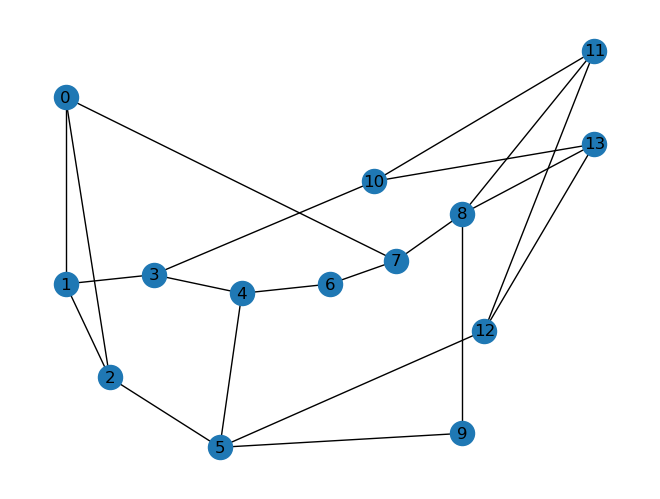

In [56]:
from ortools.linear_solver import pywraplp
channelPerBand = 96 #at 50GHz

G = get_network_rwa_json("./nsfnet.json", n_wavelengths=int(channelPerBand * 50 / spacing)) #number of wavelength set according to modulation chosen
nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)

mod = 7 # Change this value to set a different mode

# Get the parameters for the selected mode and assign to variables
datarate, entropy, spacing, reach = set_parameters(mod)

# Display the parameters
print(f"Datarate: {datarate} Gb/s")
print(f"Channel Spacing: {spacing} GHz")
print(f"Reach: {reach} km")

TM = generate_demands(G, 2)
for edge in G.edges:
    G.edges[edge]["capacity"] = (channelPerBand * 50 / spacing) * datarate 
    G.edges[edge]["n_wavelength"] = channelPerBand * 50 / spacing

print(f"\nTM: {TM}")
spectrum, all_routed = runHeuristic(G, TM, 
                                    num_spectrum=0, 
                                    plot_usage=False, 
                                    n_wavelengths=int(channelPerBand * 50 / spacing),
                                    ratePerWave=datarate,
                                    modReach=reach)

for edge in G.edges:
    print(f'\nLink: {edge}\nLength: {G.edges[edge]["length"]}\nWavelength utilization: {G.edges[edge]["available_wavelengths"]}')


TM1: [(9, 8), (8, 6), (6, 9), (13, 11), (3, 5), (8, 10), (6, 12), (10, 3), (4, 10), (12, 5), (11, 13), (12, 10)]
Heuristic:
We generated 12 demands
We routed 12 demands
Spectrum occupation is: 24
All demands were routed
ILP:
Objective value = 23.0

TM2: [(13, 8), (6, 3), (10, 7), (2, 12), (4, 6), (7, 3), (3, 2), (1, 11), (11, 8), (12, 0), (3, 6), (4, 11)]
Heuristic:
We generated 12 demands
We routed 11 demands
Spectrum occupation is: 28
Only 11 demands were routed
ILP:
Objective value = 26.0

TM3: [(0, 3), (4, 5), (5, 6), (5, 1), (5, 3), (1, 6), (6, 1), (7, 6), (12, 8), (12, 3), (9, 13), (3, 0)]
Heuristic:
We generated 12 demands
We routed 12 demands
Spectrum occupation is: 26
All demands were routed
ILP:
Objective value = 25.0

TM4: [(9, 11), (10, 8), (13, 7), (10, 13), (10, 1), (6, 0), (6, 8), (6, 1), (12, 2), (6, 1), (0, 10), (9, 12)]
Heuristic:
We generated 12 demands
We routed 12 demands
Spectrum occupation is: 28
All demands were routed
ILP:
Objective value = 26.0

TM5: [(8, 6),

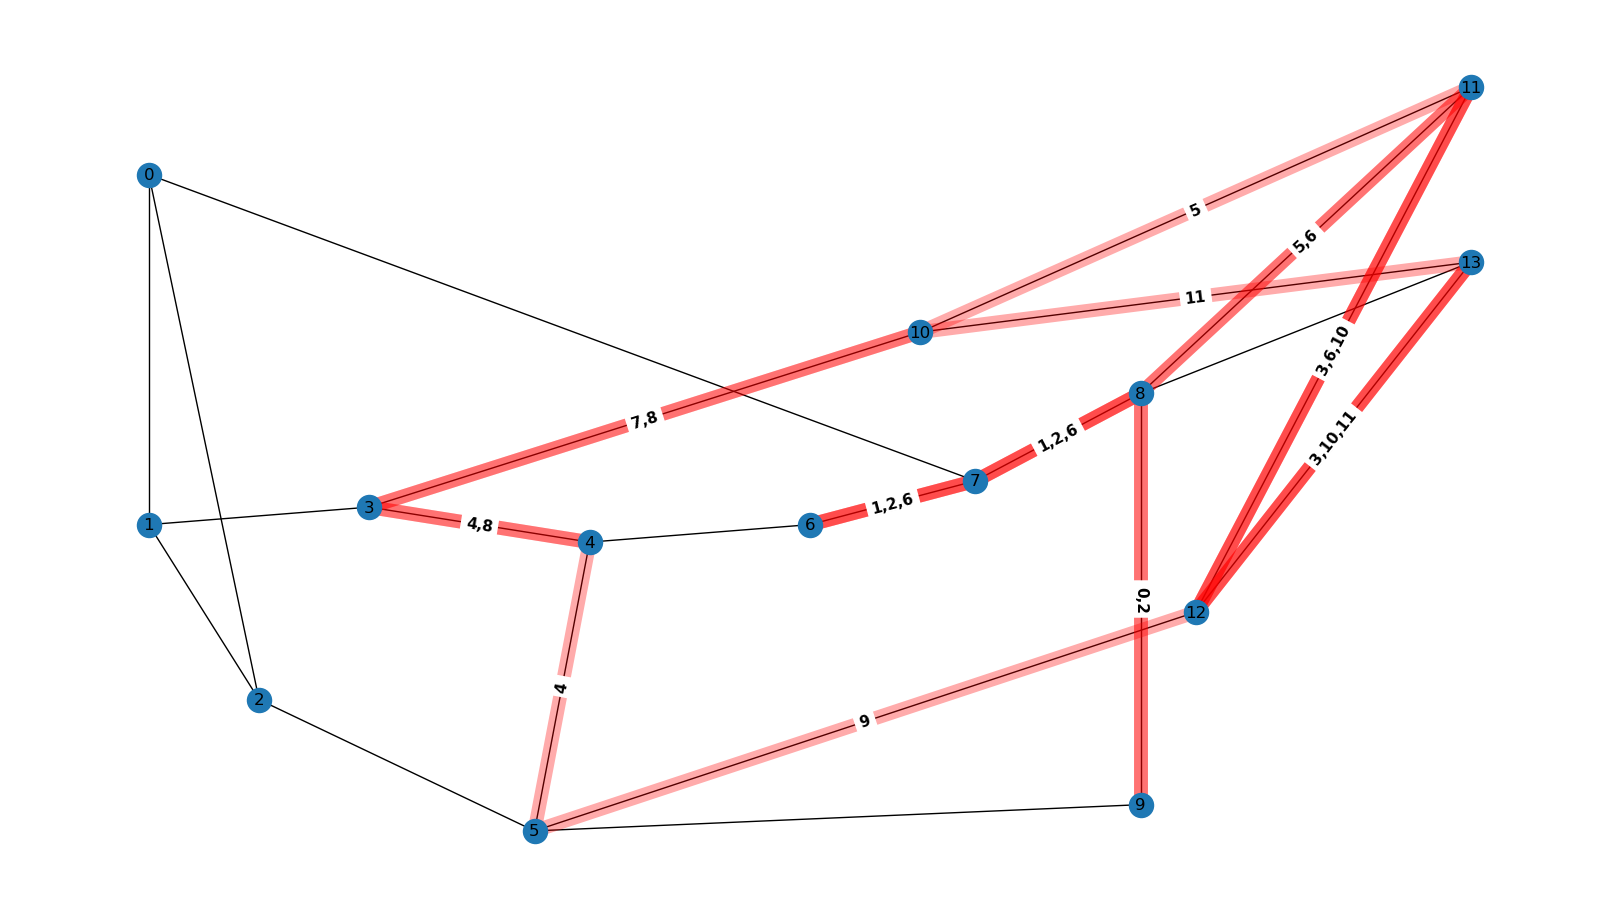

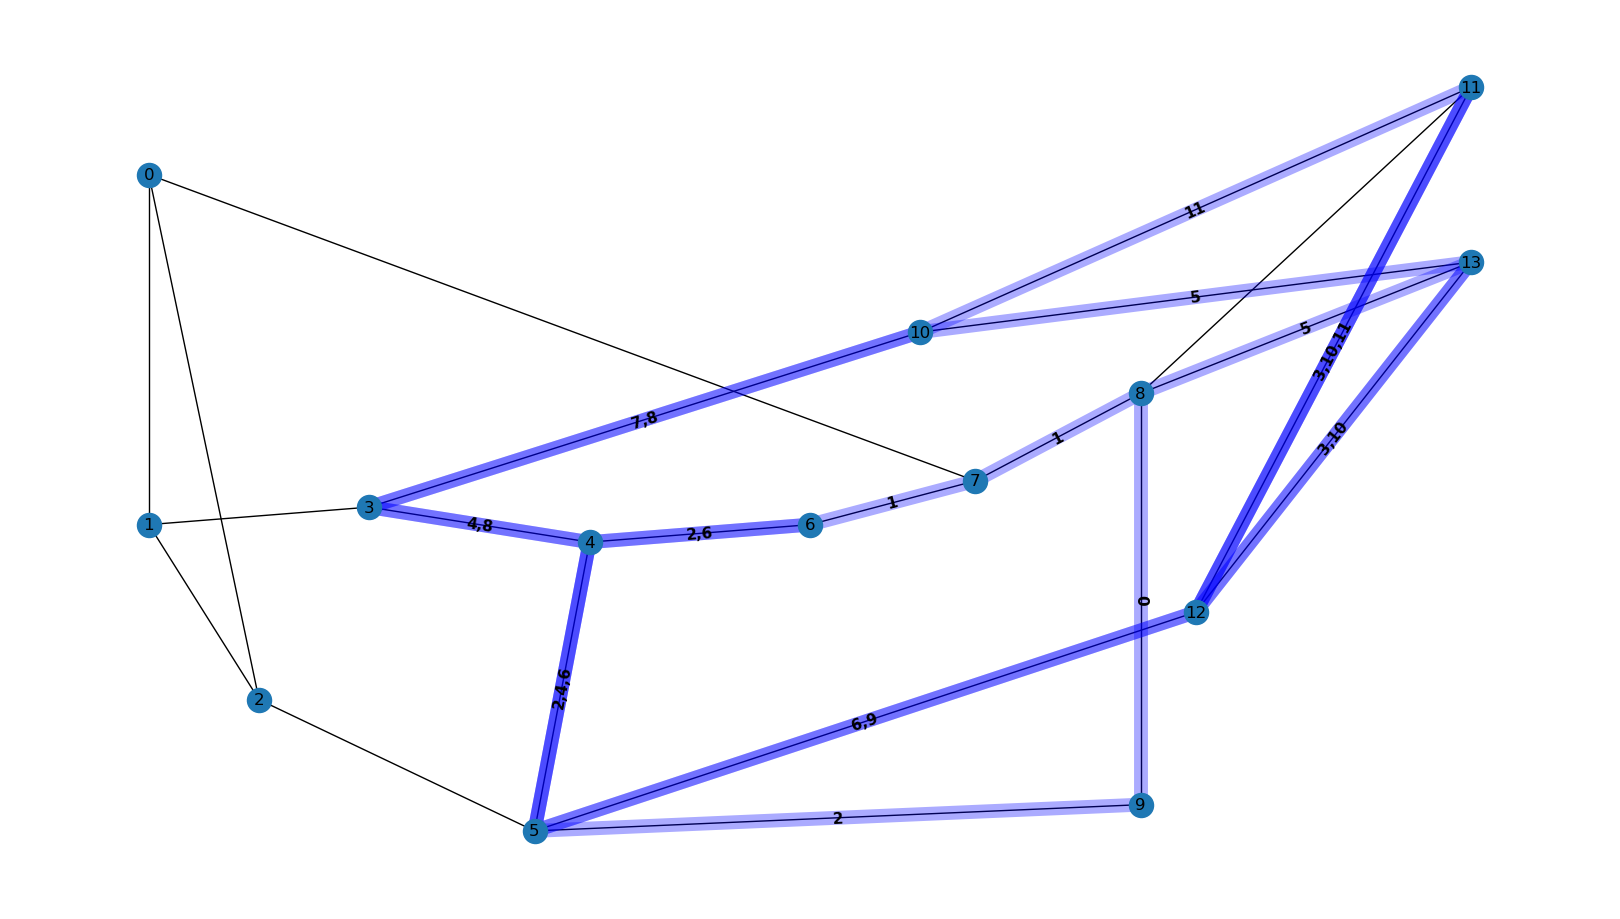

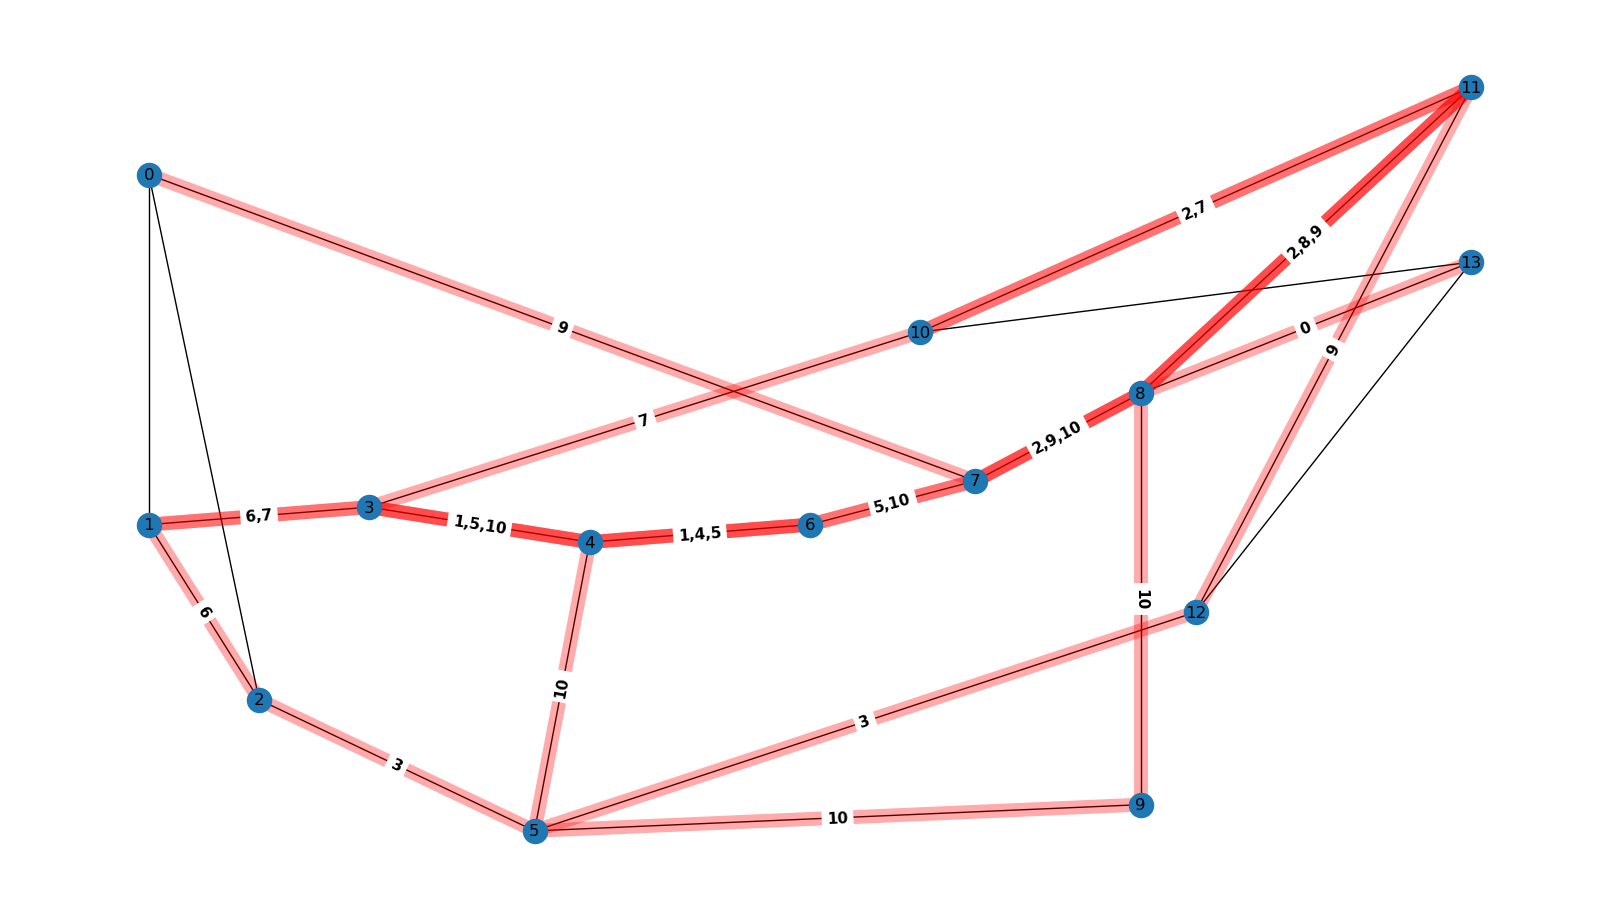

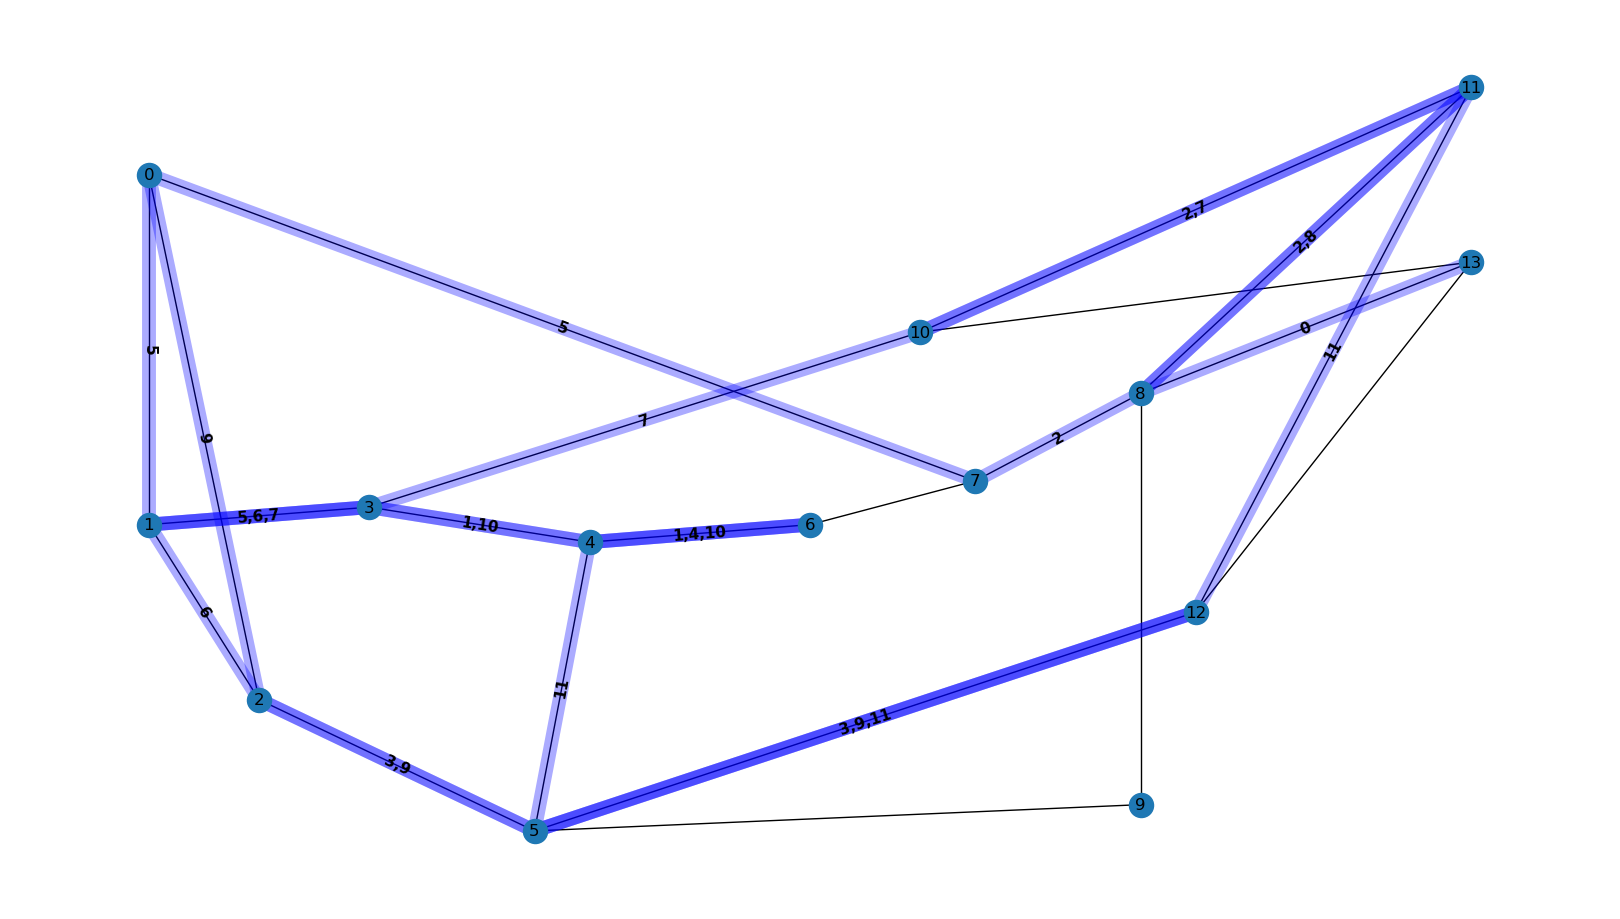

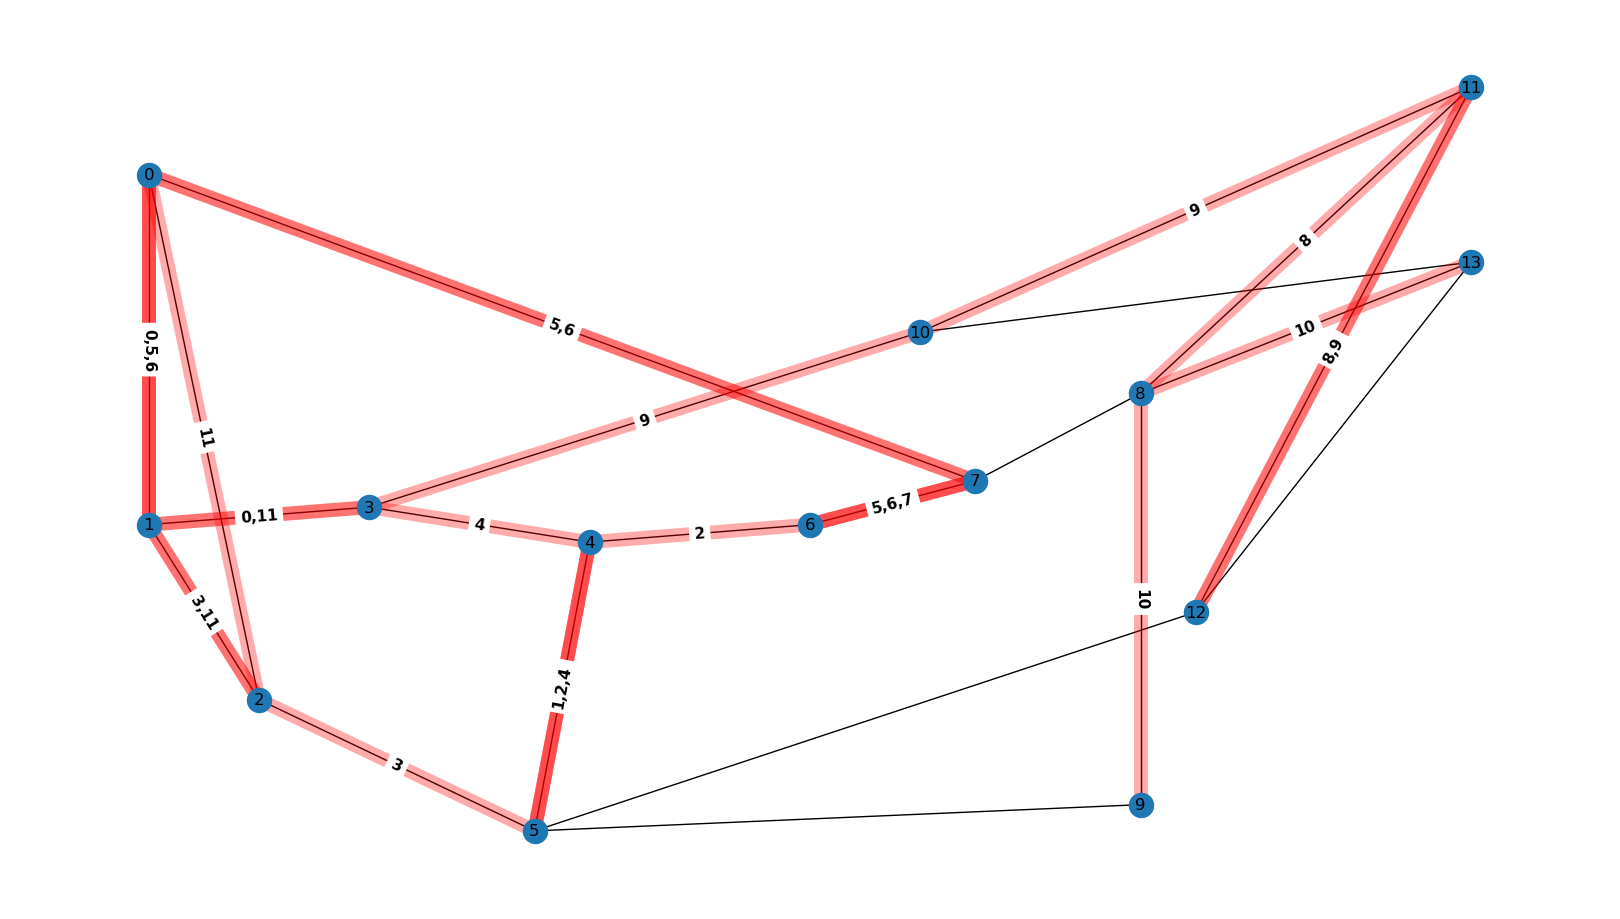

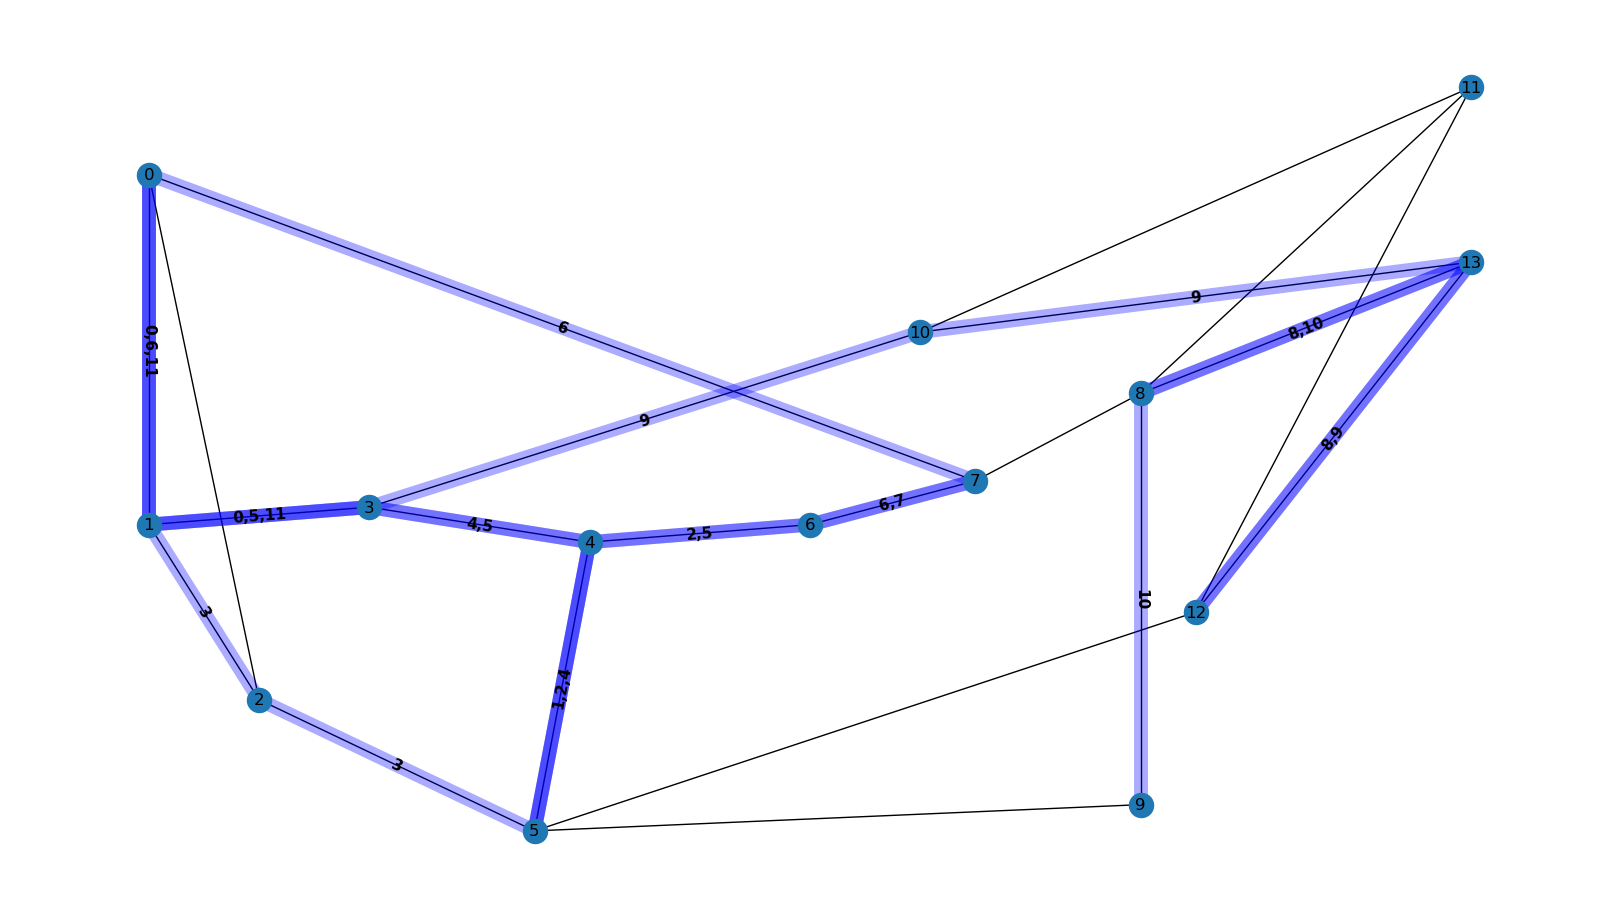

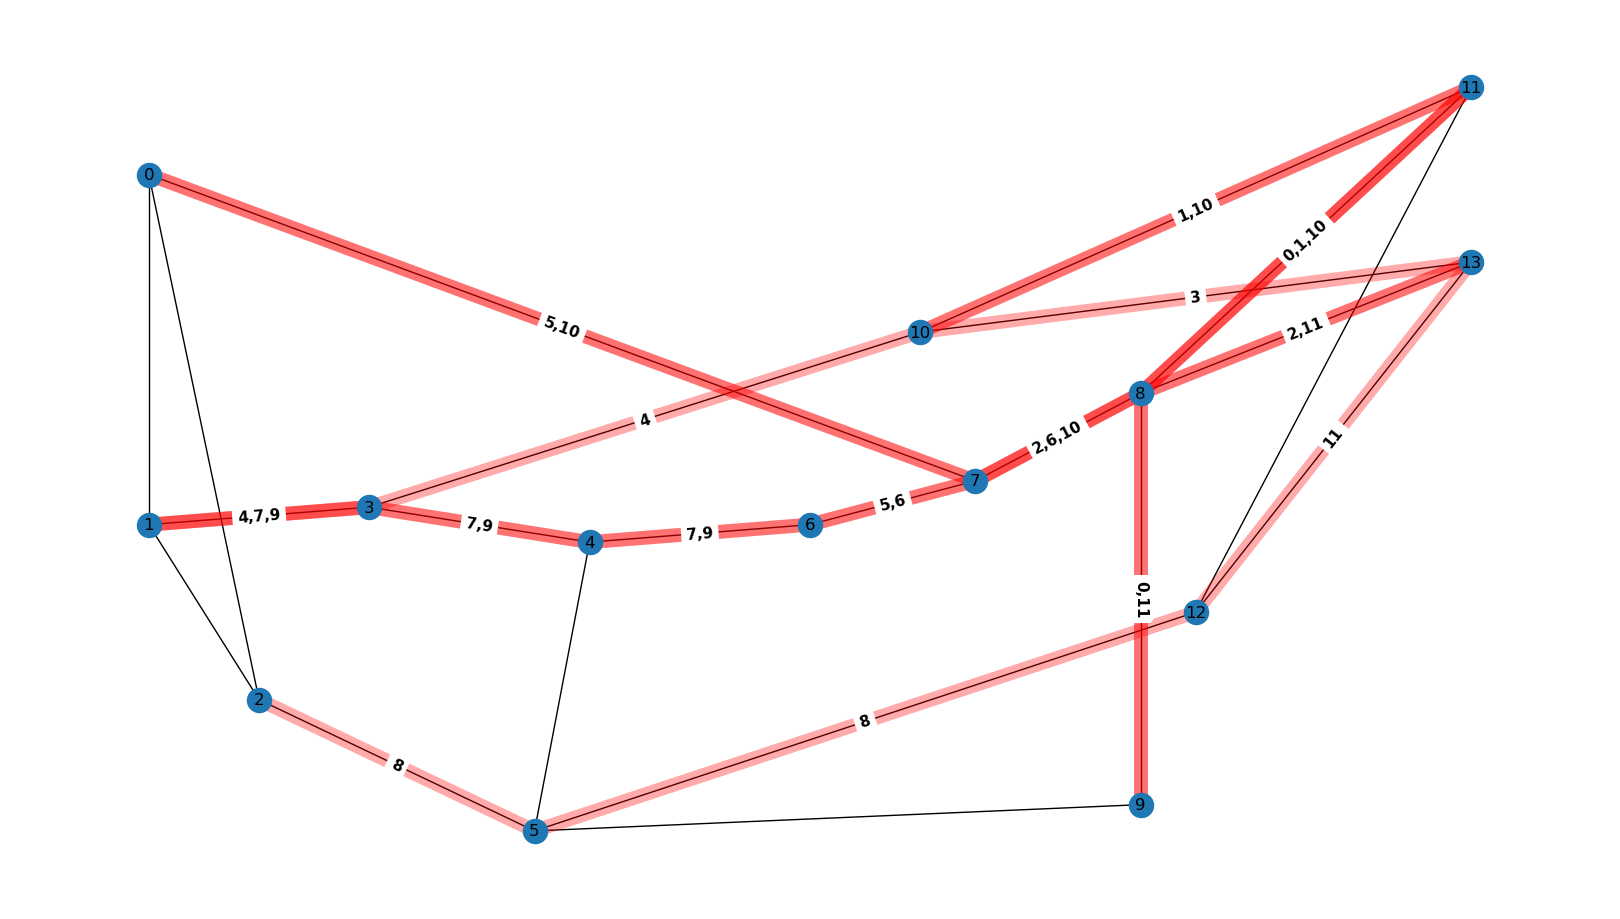

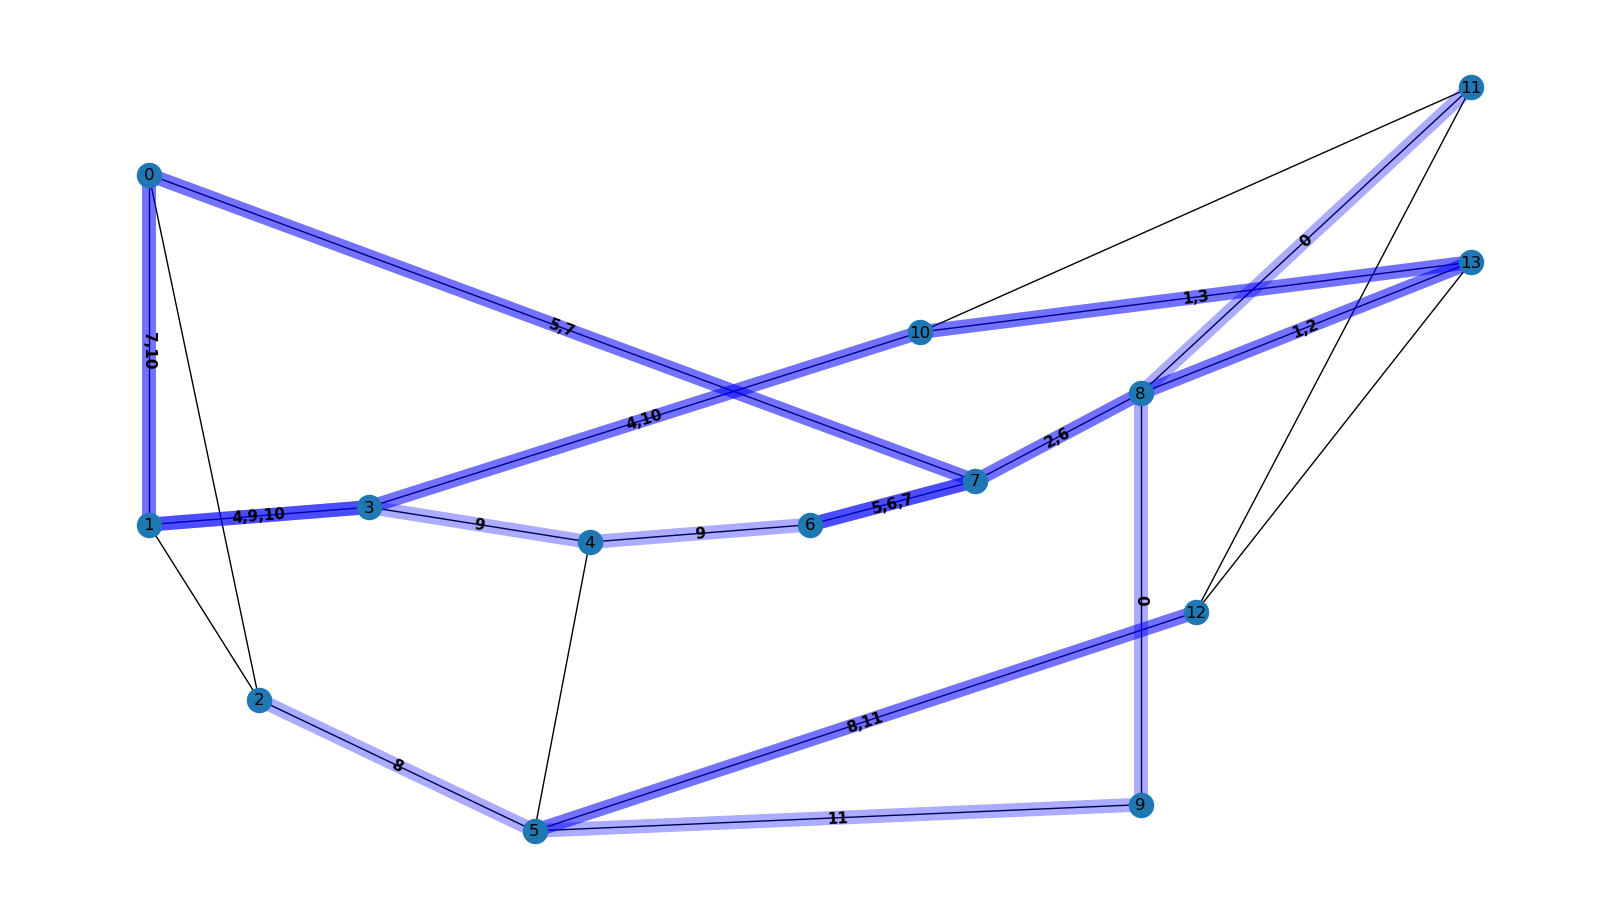

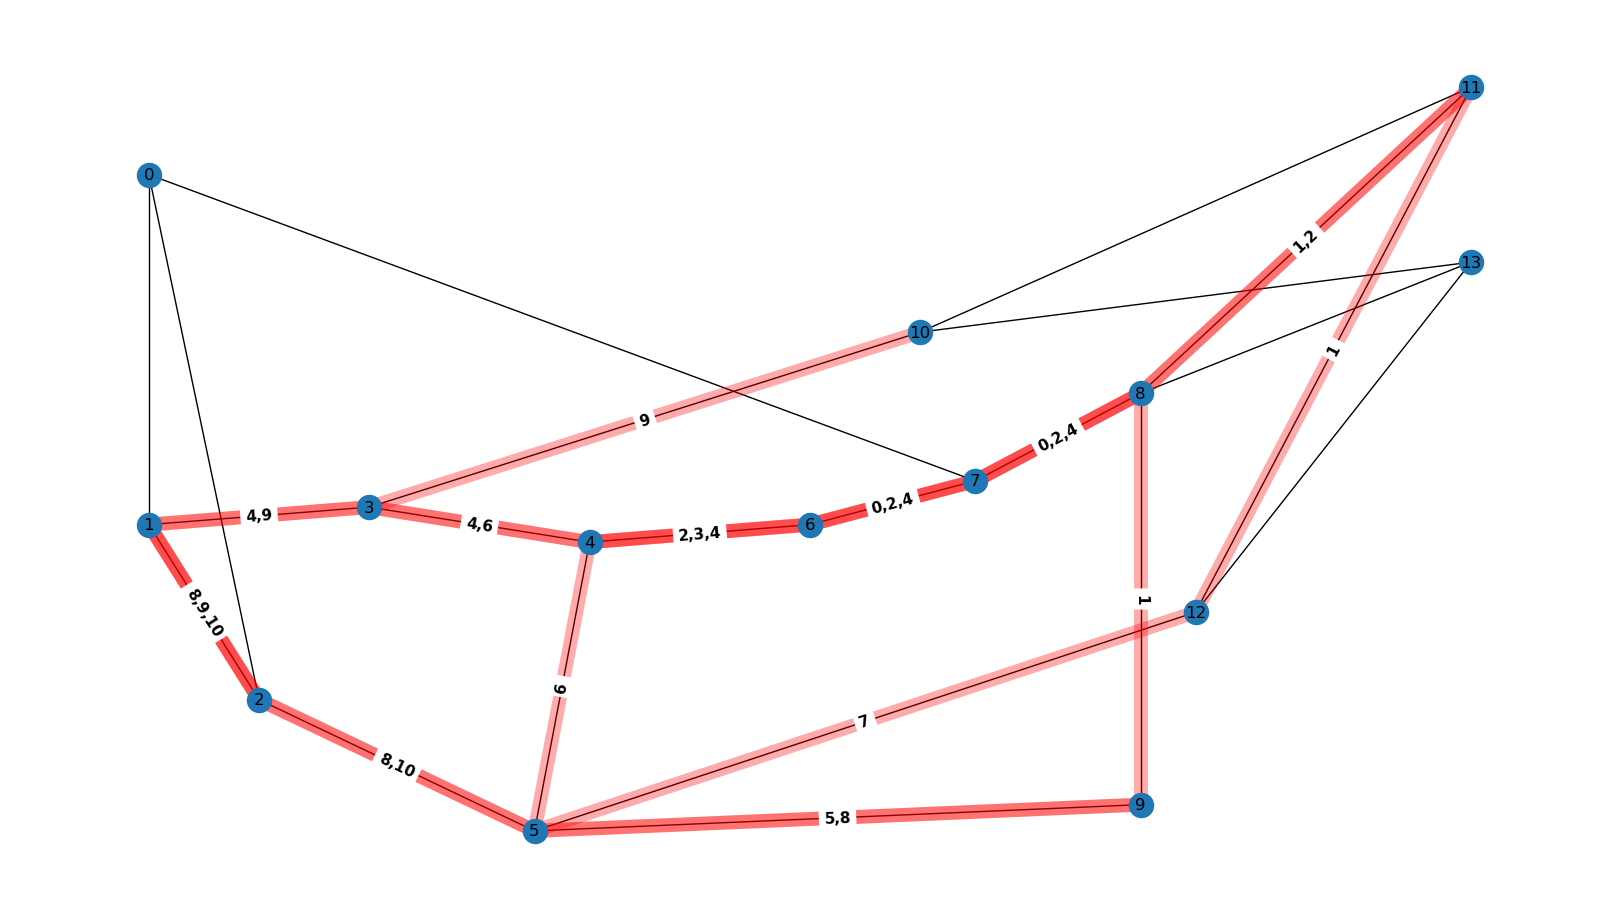

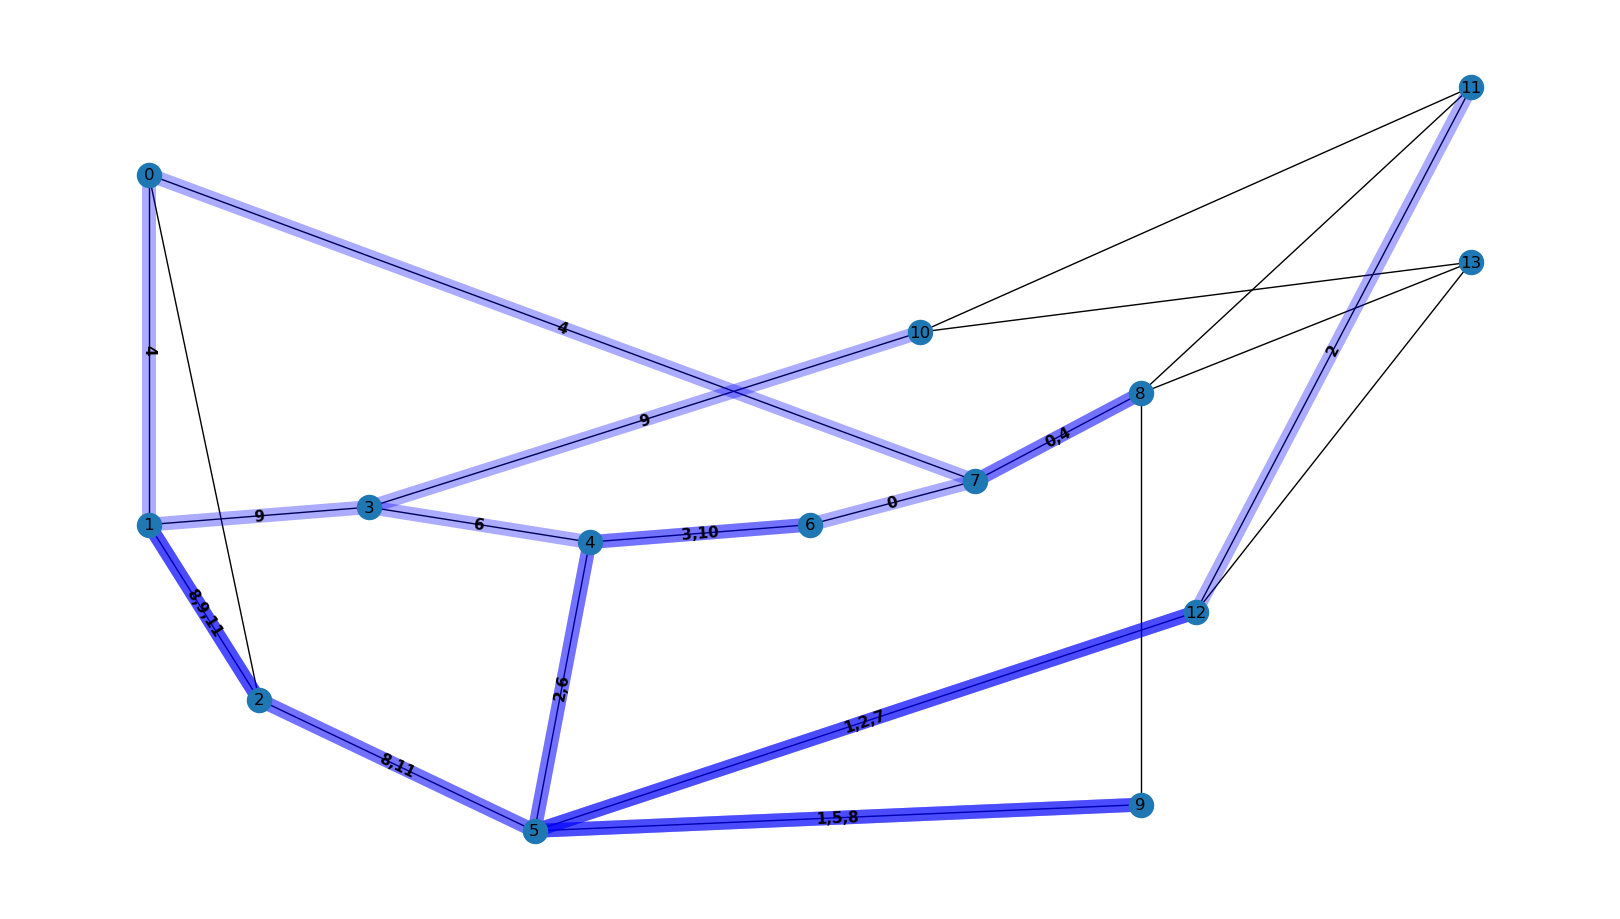

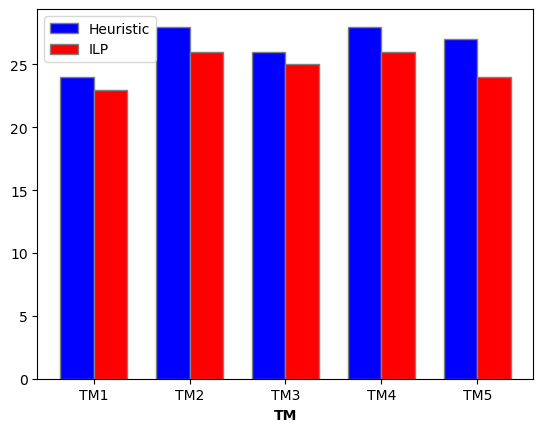

In [12]:
from ortools.linear_solver import pywraplp

num_spectrum = 0 #Initialize num_spectrum to 0
n_wavelengths = 3 #Set n_wavelengths to 3

plot_usage = True # !!! Boolean variable to plot the usage of the network !!!
stress_mode = False # !!! WATCH OUT!!! If set to True, you are beautiful !!!

if stress_mode: #retrieve statistics by running both approaches on 100 traffic matrices 
    HeuResults = []
    ILPResults = []
    for tm in range(100):
        print(f"\nTM{tm+1}:")
        G = get_network_rwa_json("./nsfnet.json", n_wavelengths=n_wavelengths)  
        TM = generate_demands(G, 12)

        # Create the SCIP solver.
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("SCIP solver not found.") 
        
        print("Heuristic:")
        HeuResults.append(runHeuristic(G, TM, num_spectrum=0, plot_usage=plot_usage, n_wavelengths=n_wavelengths))
        print("ILP:")
        (V, E, K, s, t, Lambda) = prepare_ilp(G, TM, n_wavelengths)
        ILPResults.append(runILP(G, TM, n_wavelengths, V, E, K, s, t, Lambda, solver, plot_usage=plot_usage))
        Heumean = np.mean(HeuResults)
        ILPmean = np.mean(ILPResults)

    print(f'Heuristic mean: {Heumean}')
    print(f'ILP mean: {ILPmean}')    
else:
    G = get_network_rwa_json("./nsfnet.json", n_wavelengths=n_wavelengths)  
    #Generate a list of demands using the function generate_demands with G and a total of 12 demands
    TM1 = generate_demands(G, 12)
    TM2 = generate_demands(G, 12)
    TM3 = generate_demands(G, 12)
    TM4 = generate_demands(G, 12)
    TM5 = generate_demands(G, 12)

    TMlist = [TM1, TM2, TM3, TM4, TM5]
    EuResults = []
    EuRouted = []
    ILPResults = []
    for TM in TMlist:
        print(f"\nTM{TMlist.index(TM)+1}: {TM}")
        #Load the graph G from the JSON file "./nsfnet.json" with n_wavelengths as the number of wavelengths per edge
        G = get_network_rwa_json("./nsfnet.json", n_wavelengths=n_wavelengths)  

        # Create the SCIP solver.
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("SCIP solver not found.") 
        
        print("Heuristic:")
        spectrum, all_routed = runHeuristic(G, TM, num_spectrum=0, plot_usage=plot_usage, n_wavelengths=n_wavelengths)
        EuResults.append(spectrum)
        EuRouted.append(all_routed)
        print("ILP:")
        (V, E, K, s, t, Lambda) = prepare_ilp(G, TM, n_wavelengths)
        ILPResults.append(runILP(G, TM, n_wavelengths, V, E, K, s, t, Lambda, solver, plot_usage=plot_usage))

    print(f"\nEuResults: {EuResults}")
    print(f"ILPResults: {ILPResults}")  


    #hystogram plotting with matplotlib 
    fig, ax = plt.subplots()
    barWidth = 0.35
    trace = np.arange(len(EuResults))
    r1 = [x - barWidth/2 for x in trace]
    r2 = [x + barWidth/2 for x in trace]

    plt.bar(r1, EuResults, color='b', width=barWidth, edgecolor='grey', label='Heuristic')
    plt.bar(r2, ILPResults, color='r', width=barWidth, edgecolor='grey', label='ILP')
    plt.xlabel('TM', fontweight='bold')
    plt.xticks([r for r in range(len(EuResults))], ['TM1', 'TM2', 'TM3', 'TM4', 'TM5'])
    plt.legend()
    plt.show()

